# Metadata

* **Title:** Final Project Report
* **Class:** DS 5100
* **Date:** 2 May 2023
* **Student Name:** Wyatt Scott
* **Student Net ID:** bdr6qz
* **This URL:** https://github.com/WD-Scott/montecarlo_project/blob/main/final_project/montecarlo_demo.ipynb
* **GitHub Repo URL:** https://github.com/WD-Scott/montecarlo_project

# The Monte Carlo Module

In [9]:
import pandas as pd
import numpy as np
import re
import requests
from lxml import etree
import random

#-------------------------------------------------------------------------------------------------------------------------

class Die:
    '''
    A die class with N sides/faces and W weights that users can roll to select a side/face.
    
    
    Attributes:
    -----------
    None
    
    
    Methods:
    -----------
    - initializer
    - change_weight
    - rolls
    - show_die
    '''
    
    def __init__(self, faces):
        '''
        Initializer that takes an array or list of faces of any length, then initializes weights to 1 and saves to a private dataframe.
        
        
        Parameters:
        -----------
        - faces: numpy array or a list
        '''
        self.faces = np.array(faces)
        self._faces_weights = pd.DataFrame(data = faces, columns = ['Faces'], index = range(len(faces)))
        self._faces_weights['Weights'] = np.array([1.0 for i in range(len(faces))])
        
    def change_weight(self, face, new_weight):
        '''
        A method that changes a side/face weight and checks whether side/face and weight are valid.
        
        
        Parameters:
        -----------
        - face: str or int
        - new_weight: float
        
        Raises:
        -----------
        ValueError if new_weight is not a float or convertible to a float. 
        This error will also appear if face is not included in the die.
        '''
        if not (face in list(self._faces_weights['Faces'])):
            return ValueError ("That face does not exist.")
        else:
            self._faces_weights.loc[self._faces_weights['Faces'] == face, 'Weights'] = float(new_weight)
            
    def rolls(self, rolls=1):
        '''
        A method that rolls the die one or more times but defaults to 1.
        
        
        Parameters:
        -----------
        - rolls
        
        Returns:
        -----------
        rolled_outcome: a list of the rolled outcomes.
        '''
        rolled_outcome = self._faces_weights.sample(n = rolls, weights = 'Weights', replace = True)
        return list(rolled_outcome['Faces'])
    
    def show_die(self):
        '''
        A method that shows the dataframe of faces and weights.
        
        Parameters:
        -----------
        - None
        
        Returns:
        -----------
        A pandas df of faces and weights of the die.
        '''
        return self._faces_weights
    
#-------------------------------------------------------------------------------------------------------------------------

class Game:
    '''
    A game class that rolls one or more dice of the same kind one or more times.
    
    
    Attributes:
    -----------
    None
    
    
    Methods:
    -----------
    - initializer
    - play
    - show_play
    '''
    
    def __init__(self, die_list):
        '''
        Initializer that takes a single parameter — a list of already instantiated similar Die objects.
        
        Parameters:
        -----------
        - die_list: list
        '''
        self.die_list = die_list
        
    def play(self, rolls):
        '''
        A method that takes a parameter to specify how many times the dice should be rolled.
 
 
        Parameters:
        -----------
        - rolls: int
        '''
        self._played = pd.DataFrame()
        self.rolls = rolls
        Rando_Dice = 0
        
        for die in self.die_list:
            dice_results = die.rolls(rolls=rolls)
            Rando_Dice += 1
            series = pd.Series(dice_results, name = f'Die{Rando_Dice}')
            self._played = pd.concat([self._played, series], axis = 1)
        
        self._played['Roll'] = self._played.index + 1
        self._played = self._played.set_index('Roll')
    
    def show_play(self, form = 'wide'):
        '''
        A method that shows the user the results of the most recent play.
        Takes a parameter to return the dataframe in narrow or wide form.
        This parameter defaults to wide form.
        This parameter raises an exception if the user passes an invalid option.
        
        The narrow form of the dataframe will have a two-column index with:
            * the roll number
            * the die number
            * a column for the face rolled
        
        The wide form of the dataframe will be a single-column index with:
            * the roll number
            * each die number as a column
        
        
        Parameters:
        -----------
        - form: string
        
        Raises:
        -----------
        ValueError if form is not narrow or wide.
        
        Returns:
        -----------
        A pandas df with the most recent result from the play method, including:
            * the roll number
            * the die number
            * the face rolled for each respective roll
        '''
        self.form = form
        if not (form == 'wide' or form == 'narrow'):
            raise ValueError("Input must be wide or narrow") 
        elif form == 'wide':
            return self._played
        elif form == 'narrow':
            return self._played.stack().to_frame('Face')

#-------------------------------------------------------------------------------------------------------------------------

class Analyzer:
    '''
    An analyzer class that takes the results of a single game and computes various descriptive statistical properties about it. 
    These properties and results are available as attributes of an Analyzer object.
    
    
    Attributes:
    -----------
    None
    
    
    Methods:
    -----------
    - initializer
    - face_count
    - jackpot
    - combo
    '''
    
    def __init__(self, game):
        '''
        Initializer that takes a game object as its input parameter.
        At initialization time, it also infers the data type of the die faces.
        
        Parameters:
        -----------
        - game: Game object.
        '''
        self._game_ = game
        self.die_dtype = type(game.die_list[0])
        self.JPs = 0
        self.counts_df = pd.DataFrame()
    
    def face_count(self):
        '''
        A method that computes how many times a given face is rolled in each event.
        Stores the results as a dataframe in a public attribute.
        The dataframe has an index of the roll number and face values as columns (i.e., in wide form).
        
        Parameters:
        -----------
        - None
        
        Returns:
        -----------
        A pandas df with the counts of each face value per roll, including:
            * Indexes for the roll number
            * Columns showing die face values 
        '''
        self.face_count = self._game_.show_play().apply(lambda x: x.value_counts(), axis = 1).fillna(int(0))
        self.counts_df = self.face_count
        self.counts_df.index.name = 'Roll'
        self.counts_df.columns.name = "Die Face"
        return self.counts_df
    
    def jackpot(self):
        '''
        A method that computes how many times the game resulted in all faces being identical 
            and returns an integer for the number of times to the user.
        Stores the results as a dataframe of jackpot results in a public attribute.

        Parameters:
        -----------
        - None
        
        Returns:
        -----------
        A pandas df with the rows for when a jackpot occurred, including:
            * the roll number
            * the die number
            * the respective face rolled
        '''
        self.JPs_df = pd.DataFrame()
        for i in range(1, self._game_.show_play().T.shape[1]+1):
            if ((len(set(self._game_.show_play().loc[[i]].values[0].flatten())))==1):
                temp = self._game_.show_play().loc[[i]]
                self.JPs_df = pd.concat([self.JPs_df, temp], axis=0)
        self.JPs = self.JPs_df.shape[0]
        return self.JPs
    
    def combo(self):
        '''
        A method that computes the distinct combinations of faces rolled and their counts.
        Combinations are sorted and saved as a multicolumned index.
        Stores the results as a dataframe in a public attribute.
        
        
        Parameters:
        -----------
        - None
        
        Returns:
        -----------
        A pandas df where the face values are multi-indexes and columns show the combination count.
        '''
        self.combo_df = pd.DataFrame()
        self.combo = self._game_._played.apply(lambda x: pd.Series(sorted(x)), 1).value_counts().to_frame('Count')
        self.combo_df = self.combo.sort_values(by='Count',ascending=False)
        self.combo_df.index.names = ["Face"+str(i) for i in range(1, len(self._game_.die_list)+1)]
        return(self.combo_df)

# Test Module

In [ ]:
import unittest
from montecarlo import Die, Game, Analyzer
import pandas as pd
import numpy as np
import pandas.testing as pdt

class MonteCarloTestSuit(unittest.TestCase):
    '''
    Test suite for methods and return outputs
    '''
    
    def test_die(self):
        '''
        Tests weight creation.
        '''        
        die = Die([1,2,3,4,5,6])
        x = 1
        if x not in die._faces_weights['Weights'].values:
            raise AssertionError
        
            
    def test_weight_change(self):
        '''
        Tests the weight_changed method.
        '''        
        die = Die([1,2,3,4,5,6])
        die.change_weight(3,5)
        expected = 5
        actual = die.show_die().loc[die.show_die()['Faces'] == 3, 'Weights'].values[0]
        self.assertEqual(expected, actual)
        
        
    def test_rolls(self):
        '''
        Tests the rolls method.
        '''
        die = [1,2,3,4,5,6]
        test_3 = Die(die)
        roll = test_3.rolls(3)
        self.assertEqual(len(roll), 3)
        
        
    def test_show(self):
        '''
        Tests the show_faces_weights method.
        '''
        die = [1,2,3,4,5,6]
        test_4 = Die(die)
        test_4_df = test_4.show_die()
        test_4_type = type(test_4_df)
        x = pd.DataFrame()
        pd_type = type(x)
        self.assertEqual(test_4_type, pd_type)
     
    
    def test_gameplay(self):
        '''
        Tests the play method.
        '''
        game = Game([Die([1,2,3]), Die([1,2,3]), Die([1,2,3])])
        game.play(100)
        expect_row = 100
        actual_row = game.show_play().shape[0]
        self.assertEqual(expect_row, actual_row)
        expect_col = 3
        actual_col = game.show_play().shape[1]
        self.assertEqual(expect_col, actual_col)
        

    def test_show2(self):
        '''
        Tests the show method for narrow form.
        '''        
        game = Game([Die([1,2,3]), Die([1,2,3]), Die([1,2,3])])
        game.play(100)
        expect_row = 300
        actual_row = game.show_play(form='narrow').shape[0]
        self.assertEqual(expect_row, actual_row)
        expect_col = 1
        actual_col = game.show_play(form='narrow').shape[1]
        self.assertEqual(expect_col, actual_col)
        
        
    def test_face_count(self):
        '''
        Tests the face_counts_roll method.
        '''
        testdie1 = Die([1,2,3])
        testdie2 = Die([1,2,3])
        testdie_lst = ([testdie1, testdie2])
        
        testgame = Game(testdie_lst)
        testgame.play(2)
        test_analyze = Analyzer(testgame)
        test_df = test_analyze.face_count()
        shape = test_df.shape[0]
        expected = 2
        actual = shape
        self.assertEqual(expected, actual)
        

    def test_jp(self):
        '''
        Tests the jackpot method.
        '''
        testdie1 = Die([1,2,3])
        testdie2 = Die([1,2,3])
        testdie3 = Die([1,2,3])
        testdie_lst = ([testdie1, testdie2, testdie3])
        
        testgame = Game(testdie_lst)
        testgame.play(3)
        analyze = Analyzer(testgame)
        jps = analyze.jackpot()
        self.assertTrue(type(jps) == int)
    

    def test_combo(self):
        '''
        Tests the combo method.
        '''
        testdie1 = Die([1,2,3])
        testdie2 = Die([1,2,3])
        testdie3 = Die([1,2,3])
        testdie_lst = ([testdie1, testdie2, testdie3])
        
        testgame = Game(testdie_lst)
        testgame.play(3)
        test_analyze = Analyzer(testgame)
        test_df = test_analyze.combo().size
        self.assertGreater(test_df, 0)
        
if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False, verbosity=3)     

# Test Results

In [11]:
!python montecarlo_tests.py

test_combo (__main__.MonteCarloTestSuit)
Tests the combo method. ... ok
test_die (__main__.MonteCarloTestSuit)
Tests weight creation. ... ok
test_face_count (__main__.MonteCarloTestSuit)
Tests the face_counts_roll method. ... ok
test_gameplay (__main__.MonteCarloTestSuit)
Tests the play method. ... ok
test_jp (__main__.MonteCarloTestSuit)
Tests the jackpot method. ... ok
test_rolls (__main__.MonteCarloTestSuit)
Tests the rolls method. ... ok
test_show (__main__.MonteCarloTestSuit)
Tests the show_faces_weights method. ... ok
test_show2 (__main__.MonteCarloTestSuit)
Tests the show method for narrow form. ... ok
test_weight_change (__main__.MonteCarloTestSuit)
Tests the weight_changed method. ... ok

----------------------------------------------------------------------
Ran 9 tests in 0.022s

OK


# Scenarios

In [4]:
from montecarlo import Die, Game, Analyzer
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Scenario 1: A 2-headed coin

### (1.1)
**Directions:** Create a fair coin and one unfair coin, in which one of the faces has a weight of 5 and the others.

In [5]:
fair_coin = Die(['H', 'T'])
unfair_coin = Die(['H', 'T'])
unfair_coin.change_weight('T', 5)

### (1.2)
**Directions:** Play a game of 1,000 flips with all fair dice

In [6]:
fair_game = Game([fair_coin, fair_coin, fair_coin])
fair_game.play(1000)

### (1.3)
**Directions:** Play a game of 1,000 flips with two unfair dice and one fair die.

In [7]:
unfair_game = Game([unfair_coin, unfair_coin, fair_coin])
unfair_game.play(1000)

### (1.4)
**Directions:** For each game, use an Analyzer object to determine the relative frequency of jackpots - getting all Hs or all Ts.

In [8]:
fair_JPs = Analyzer(fair_game)
unfair_JPs = Analyzer(unfair_game)
rel_freq_fair = fair_JPs.jackpot()
rel_freq_unfair = unfair_JPs.jackpot()

### (1.5)
**Directions:** Compute the relative frequency as the number of jackpots over the total number of rolls.

In [9]:
rel_fair_freq = rel_freq_fair/1000
rel_unfair_freq = rel_freq_unfair/1000

### (1.6)
**Directions:** Show your results, comparing the two relative frequencies in a simple bar chart.

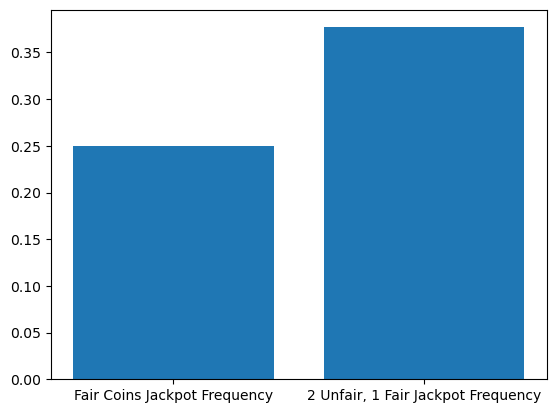

In [10]:
plt.figure()
plt.bar(['Fair Coins Jackpot Frequency', '2 Unfair, 1 Fair Jackpot Frequency'],
        [rel_fair_freq, rel_unfair_freq])
plt.show()

## Senario 2: A 6-sided die

### (2.1)
**Directions:** Create a fair die and two unfair dice, all of six sides with the faces 1 through 6. One unfair die (Type 1) will weight 6 five times more than the others (i.e. it has a weight of 5 and the others a weight of 1 each). The other unfair die (Type 2) will weight 1 five times more than the others.

In [11]:
fair_die = Die([1,2,3,4,5,6])
unfair_1 = Die([1,2,3,4,5,6])
unfair_2 = Die([1,2,3,4,5,6])

In [12]:
unfair_1.change_weight(6, 5)
unfair_2.change_weight(1, 5)

### (2.2)
**Directions:** Play a game of 10,000 rolls with 5 fair dice.

In [13]:
fair_game_die = Game([fair_die, fair_die, fair_die, fair_die, fair_die])
fair_game_die.play(10000)

### (2.3)
**Directions:** Play a game of 10,000 rolls with 2 unfair dice of Type 1, 1 unfair die of Type 2, and the rest fair dice.

In [14]:
unfair_game_die = Game([unfair_1, unfair_1, unfair_2, fair_die, fair_die])
unfair_game_die.play(10000)

### (2.4)
**Directions:** For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies in a simple bar chart.

In [15]:
fair_die_JPs = Analyzer(fair_game_die)
unfair_die_JPs = Analyzer(unfair_game_die)

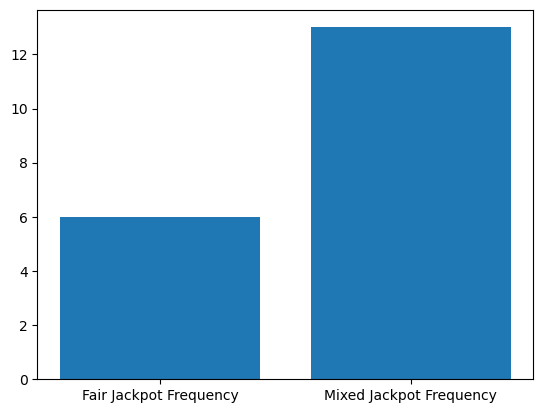

In [16]:
rel_freq_fair_die = fair_die_JPs.jackpot()
rel_freq_unfair_die = unfair_die_JPs.jackpot()

plt.figure()
plt.bar(['Fair Jackpot Frequency', 'Mixed Jackpot Frequency'],
        [rel_freq_fair_die, rel_freq_unfair_die])
plt.show()

### (2.5)
**Directions:** Compute the 10 most frequent combinations of faces for each game. Plot each of these as bar charts.

<AxesSubplot:title={'center':'Unfair Game'}, xlabel='Face1,Face2,Face3,Face4,Face5'>

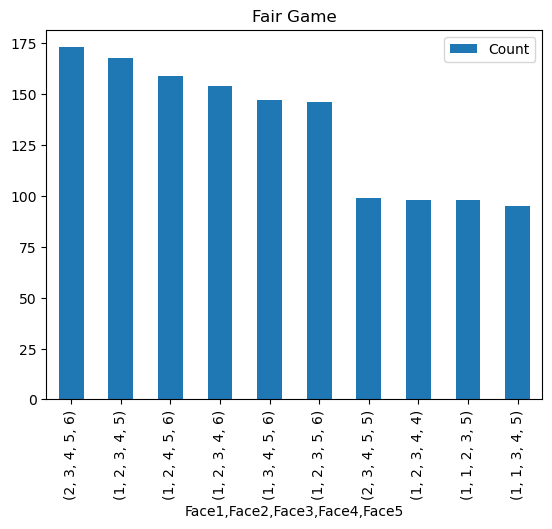

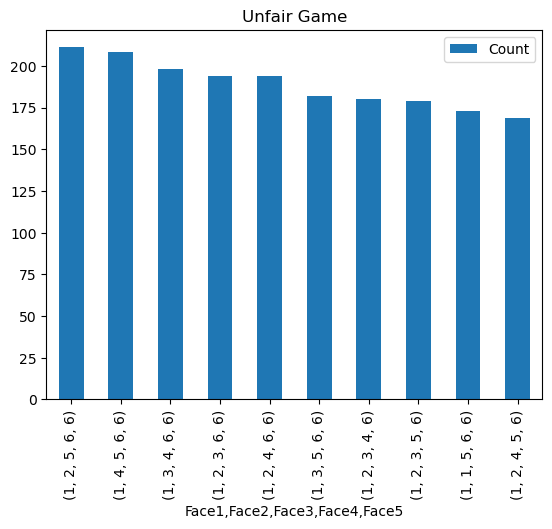

In [17]:
Fair_combos = fair_die_JPs.combo().head(10)
Fair_combos.plot.bar(title="Fair Game")

Unfair_combos = unfair_die_JPs.combo().head(10)
Unfair_combos.plot.bar(title="Unfair Game")

## Scenario 3: Letters of the Roman Alpha

### (3.1)
**Directions:** Create a 'die' of letters from a to z with weights based on their frequency of usage.

In [18]:
Roman_Alphabet = Die(["A", "B", "C", "D", "E", 
                 "F", "G", "H", "I", 'J', 
                 'K','L', 'M', 'N', 'O', 
                 'P', 'Q', 'R', 'S', 'T', 
                 'U', 'V', 'W', 'X', 'Y', 'Z'])

Roman_Alphabet.change_weight("A",8.4966)
Roman_Alphabet.change_weight("B",2.0720)
Roman_Alphabet.change_weight("C",4.5388)
Roman_Alphabet.change_weight("D",3.3844)
Roman_Alphabet.change_weight("E",11.1607)
Roman_Alphabet.change_weight("F",1.8121)
Roman_Alphabet.change_weight("G",2.4705)
Roman_Alphabet.change_weight("H",3.0034)
Roman_Alphabet.change_weight("I",7.5448)
Roman_Alphabet.change_weight("J",0.1965)
Roman_Alphabet.change_weight("K",1.1016)
Roman_Alphabet.change_weight("L",5.4893)
Roman_Alphabet.change_weight("M",3.0129)
Roman_Alphabet.change_weight("N",6.6544)
Roman_Alphabet.change_weight("O",7.1635)
Roman_Alphabet.change_weight("P",3.1671)
Roman_Alphabet.change_weight("Q",0.1962)
Roman_Alphabet.change_weight("R",7.5809)
Roman_Alphabet.change_weight("S",5.7351)
Roman_Alphabet.change_weight("T",6.9509)
Roman_Alphabet.change_weight("U",3.6308)
Roman_Alphabet.change_weight("V",1.0074)
Roman_Alphabet.change_weight("W",1.2899)
Roman_Alphabet.change_weight("X",0.2902)
Roman_Alphabet.change_weight("Y",1.7779)
Roman_Alphabet.change_weight("Z",0.2722)

### (3.2)
**Directions:** Play a game involving 5 of these dice with 1,000 rolls.

In [19]:
letters_list = ([Roman_Alphabet, Roman_Alphabet, Roman_Alphabet, Roman_Alphabet, Roman_Alphabet])
letters_game = Game(letters_list)
letters_game.play(1000)

### (3.3)
**Directions:** How many combos can you see that look like actual English words? A 'combo' here just means resulting sequence, not literally combination as opposed to permutation.

In [20]:
letters_game.show_play()

,Die1,Die2,Die3,Die4,Die5
Roll,,,,,
1,L,O,R,I,B
2,I,E,I,A,D
3,I,E,P,U,E
4,E,Y,A,S,T
5,O,N,M,D,M
...,...,...,...,...,...
996,T,H,H,I,V
997,S,T,T,U,E
998,N,P,E,A,N


**Answer:** I don't see any English words using the `show_play` method from the `Game` class. So, I will look at a larger slice of the dataframe.

In [21]:
result = letters_game.show_play()

In [22]:
words = []

result_slice1 = result.iloc[:50]

for index, rows in result_slice1.iterrows():
    word_list = [(rows.Die1), (rows.Die2), (rows.Die3), (rows.Die4), (rows.Die5)]
    no_seps_words = '[' + ' '.join(word_list) + ']'
    words.append(no_seps_words)

for i in range(len(words)):
    print(words[i])

[L O R I B]
[I E I A D]
[I E P U E]
[E Y A S T]
[O N M D M]
[L U C V N]
[T D G B B]
[L F H I E]
[B P I C I]
[D E U O T]
[S S O I I]
[V C A M K]
[T C R A I]
[R M R E I]
[O O P S P]
[E K O Y A]
[R D M A N]
[E H A A U]
[O N E H S]
[I A A O K]
[L U G A O]
[T Y T N B]
[Y H M O M]
[M A N M E]
[U W E S E]
[E P I U N]
[T I K B N]
[U S G C S]
[N C E C M]
[I I U T O]
[G S A D G]
[H E A A D]
[N E S I N]
[L L R T R]
[U T P O O]
[R A W D R]
[S U Y A T]
[S T A I H]
[E O C N E]
[A O A E R]
[E A I A D]
[A C S S T]
[R L E I K]
[I S A L C]
[I R D E M]
[D E U I E]
[I I R Y E]
[R O T P T]
[L H L H S]
[O N O A S]


**Answer**: I still see no English words, at least not in the first 50 rows.

### (3.4)
**Directions:** Based on your eye count, what is the relative frequency of these words versus the rest?

**Answer**: I do not see any words by eye count, so the relative frequencies are equal to (0)

# Directory Listing
**Directions:** A code block that executes the following bash command:
``!ls -lRF -o``

In [54]:
!ls -lRF -o

total 256
drwxr-xr-x  7 wyattscott     224 Apr  9 16:22 Montecarlo_Simulator.egg-info/
drwxr-xr-x  6 wyattscott     192 Apr  4 21:38 build/
drwxr-xr-x  7 wyattscott     224 Apr 13 13:30 montecarlo/
-rw-r--r--@ 1 wyattscott  117378 Apr 13 13:35 montecarlo_demo.ipynb
-rw-r--r--@ 1 wyattscott    3743 Apr 13 13:30 montecarlo_tests.py
-rw-r--r--@ 1 wyattscott     337 Mar 19 13:40 setup.py
-rw-r--r--  1 wyattscott     809 Mar 19 13:50 test_results.txt

./Montecarlo_Simulator.egg-info:
total 40
-rw-r--r--  1 wyattscott  205 Apr  9 16:22 PKG-INFO
-rw-r--r--  1 wyattscott  275 Apr  9 16:22 SOURCES.txt
-rw-r--r--  1 wyattscott    1 Apr  9 16:22 dependency_links.txt
-rw-r--r--  1 wyattscott   13 Apr  9 16:22 requires.txt
-rw-r--r--  1 wyattscott   11 Apr  9 16:22 top_level.txt

./build:
total 8
-rw-r--r--  1 wyattscott  1494 Apr  4 21:38 Untitled.ipynb
drwxr-xr-x  2 wyattscott    64 Apr  9 16:22 bdist.macosx-10.9-x86_64/
drwxr-xr-x  3 wyattscott    96 Mar 19 22:08 lib/

./build/bdist.macosx-10.9-

# Installation Output Listing    
**Directions:** A code block that executes the code to install your your package and outputs a successful installation.

In [55]:
!pip install .

Processing /Users/wyattscott/Documents/Data Science/DS5100/Project
  Preparing metadata (setup.py) ... done
  Created wheel for Montecarlo-Simulator: filename=Montecarlo_Simulator-1.0.0-py3-none-any.whl size=3945 sha256=8d0ab289cb222436f3a4e3e1cb8f74a96c88b7a785d34c50d385aa7e266f04be
  Stored in directory: /private/var/folders/ty/8whcck9n7k14xzdn38j7322w0000gn/T/pip-ephem-wheel-cache-kgc7jjtl/wheels/d9/3a/fb/f177161071f287db36b9905c997b78dcac5e4e2116591b39e7
Successfully built Montecarlo-Simulator
  Attempting uninstall: Montecarlo-Simulator
    Found existing installation: Montecarlo-Simulator 1.0.0
    Uninstalling Montecarlo-Simulator-1.0.0:
      Successfully uninstalled Montecarlo-Simulator-1.0.0
